In [1]:
import pandas as pd
import numpy as np
import itertools
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.decomposition import PCA
import plotly.express as px

from yellowbrick.features.pca import PCADecomposition
from dateutil import parser
from datetime import date

In [2]:
rawData = pd.read_csv("./marketing_data.csv")
data = rawData

data.rename(columns={' Income ':'Income'}, inplace=True)
data['Income'] = data['Income'].str.replace(',', '').str.replace('$', '').astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Covert categorial column to the correct column type

In [3]:
data["Education"] = data["Education"].astype("category")
data["Marital_Status"] = data["Marital_Status"].astype("category")
data["Kidhome"] = data["Kidhome"].astype("category")
data["Teenhome"] = data["Teenhome"].astype("category")
data["Complain"] = data["Complain"].astype("category")
data["Country"] = data["Country"].astype("category")

In [4]:
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   2240 non-null   int64   
 1   Year_Birth           2240 non-null   int64   
 2   Education            2240 non-null   category
 3   Marital_Status       2240 non-null   category
 4   Income               2216 non-null   float64 
 5   Kidhome              2240 non-null   category
 6   Teenhome             2240 non-null   category
 7   Dt_Customer          2240 non-null   object  
 8   Recency              2240 non-null   int64   
 9   MntWines             2240 non-null   int64   
 10  MntFruits            2240 non-null   int64   
 11  MntMeatProducts      2240 non-null   int64   
 12  MntFishProducts      2240 non-null   int64   
 13  MntSweetProducts     2240 non-null   int64   
 14  MntGoldProds         2240 non-null   int64   
 15  NumDealsPurchases    

There are 24 null values for income column, imputed with mean value


In [5]:
data["Income"].mean()
data['Income'] = np.where(data["Income"].isnull(), data["Income"].mean(), data["Income"])

# Data visualization by column against the target

In [6]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style="darkgrid")

### Reponse Rate column

<AxesSubplot:xlabel='Response', ylabel='count'>

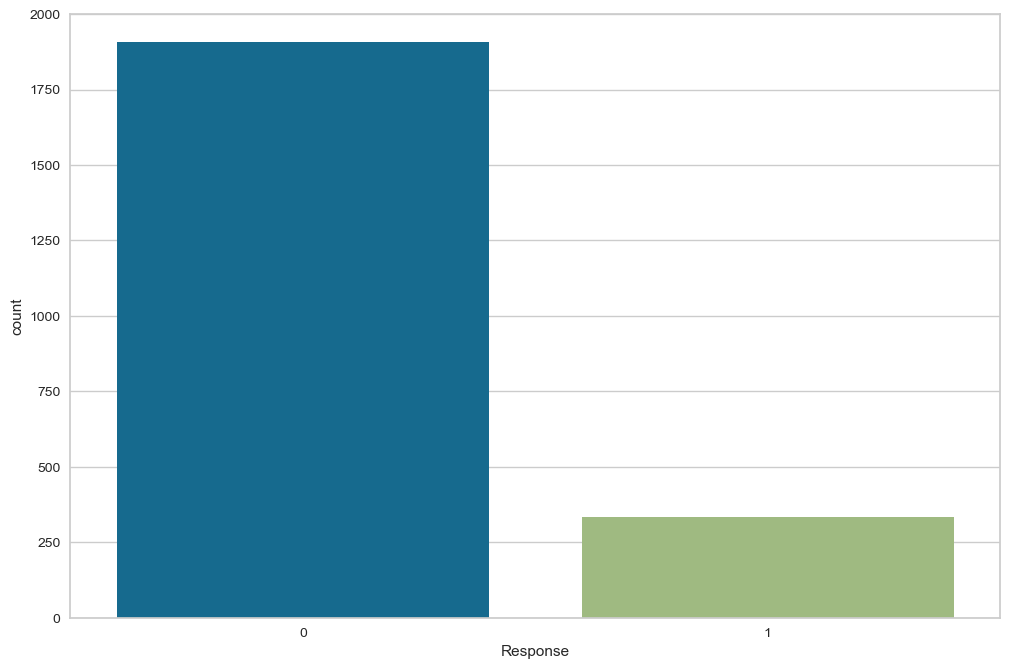

In [7]:
sns.countplot(x="Response", data=data)

## Numeric columns

### Income

In [8]:
data["Income"] = np.where(data["Income"].isnull(), 0, data["Income"])

(array([  2.,   6.,  22.,  74., 397., 946., 784.,   8.,   0.,   1.]),
 array([3.23829707, 3.49685826, 3.75541945, 4.01398063, 4.27254182,
        4.53110301, 4.7896642 , 5.04822539, 5.30678658, 5.56534777,
        5.82390896]),
 <BarContainer object of 10 artists>)

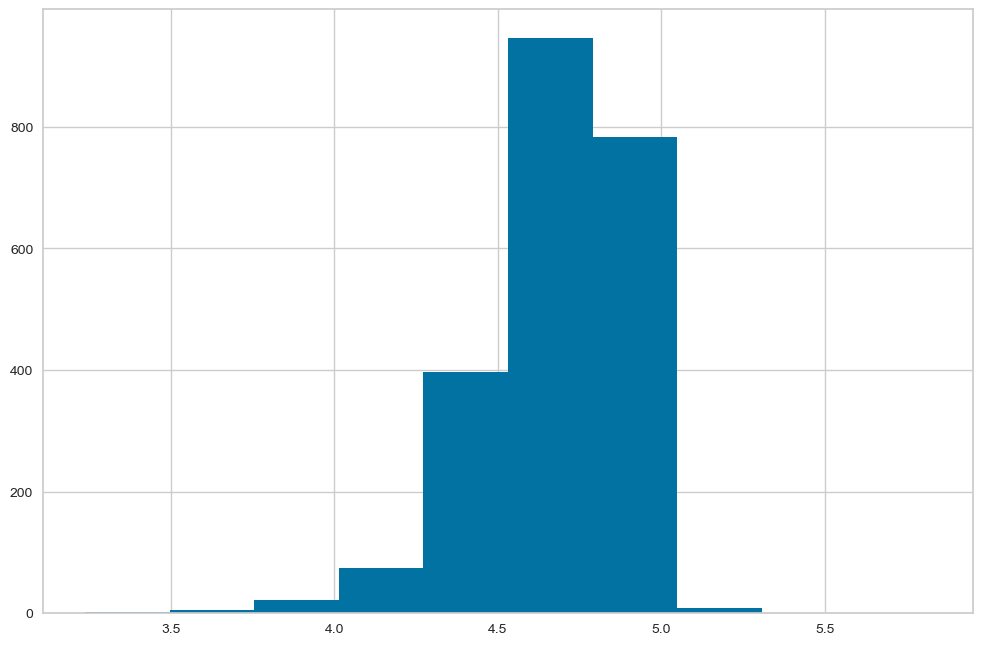

In [9]:
plt.hist(np.log10(data["Income"] + 1))

Text(0.5, 0, 'Response 1')

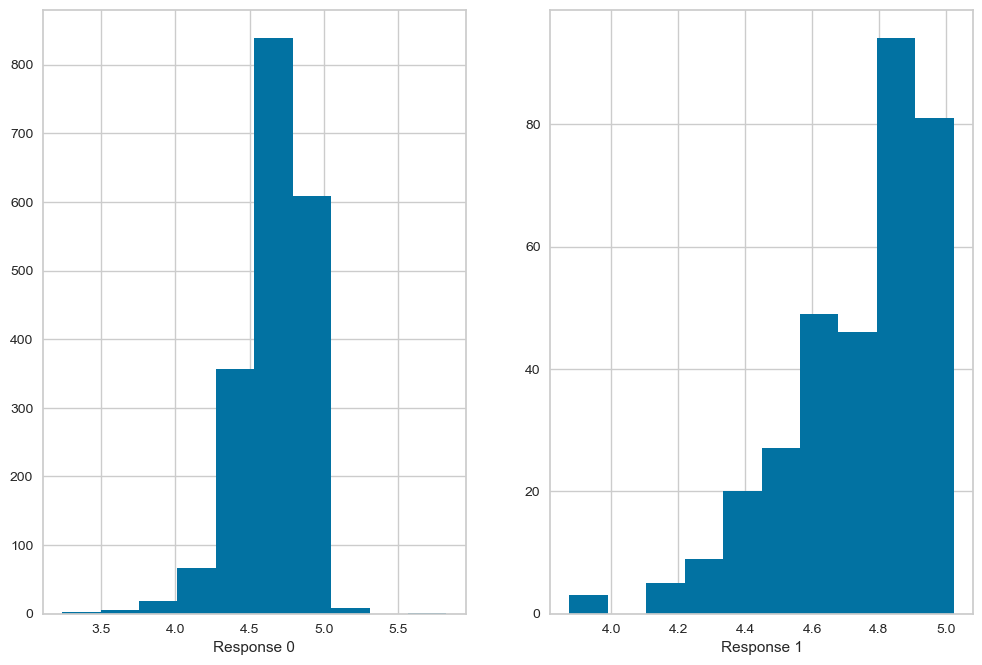

In [10]:
incomeData = data[["Income","Response"]]
response0 = incomeData[incomeData["Response"]==0]
response1 = incomeData[incomeData["Response"]==1]
fig, axs = plt.subplots(1, 2)

axs[0].hist(np.log10(response0["Income"] + 1))
axs[0].set_xlabel('Response 0')
axs[1].hist(np.log10(response1["Income"] + 1))
axs[1].set_xlabel('Response 1')

### Convert DT_Customer from string to number of year loyality

In [31]:
from datetime import datetime
convertedDate = pd.to_datetime(data["Dt_Customer"], infer_datetime_format=True)

In [32]:
mostRecentDate = convertedDate.max()
daysDiff = mostRecentDate - convertedDate
daysDiff = daysDiff.dt.days
data["yearsLoyality"] = daysDiff // 365

In [33]:
data["yearsLoyality"]

0        0
1        0
2        0
3        8
4        9
        ..
2235    10
2236     1
2237     2
2238     1
2239     5
Name: yearsLoyality, Length: 2240, dtype: int64

(array([1364.,   79.,   76.,  177.,   56.,   56.,  158.,   84.,   81.,
         109.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

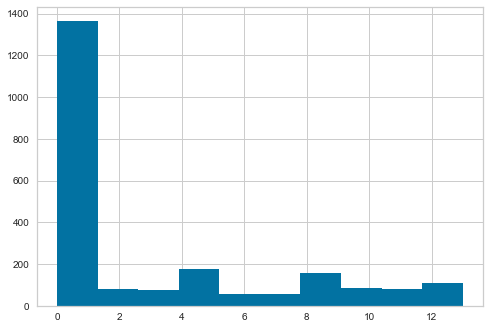

In [34]:
plt.hist(data["yearsLoyality"])

## Categorial columns

### Kid home

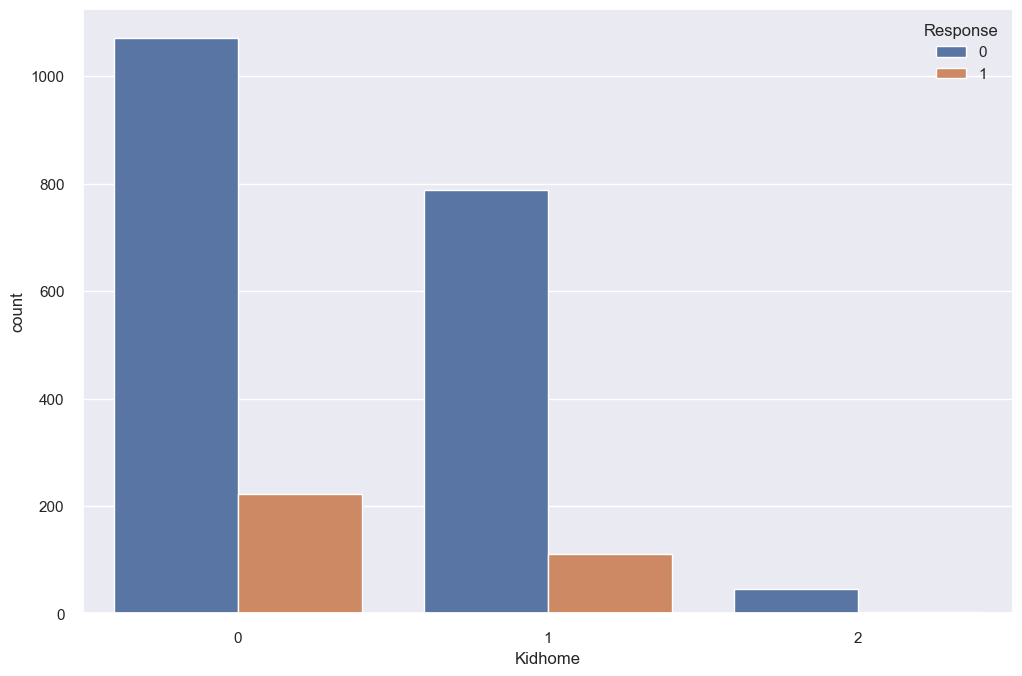

In [11]:
ax = sns.countplot(x="Kidhome", hue="Response", data=data)

In [13]:
(rawData[["Kidhome", "Response"]].groupby(['Kidhome']).sum()/rawData[["Kidhome", "Response"]].groupby(['Kidhome']).count()).sort_values('Response')

,Response
Kidhome,
2,0.041667
1,0.122358
0,0.171694


### Teen home

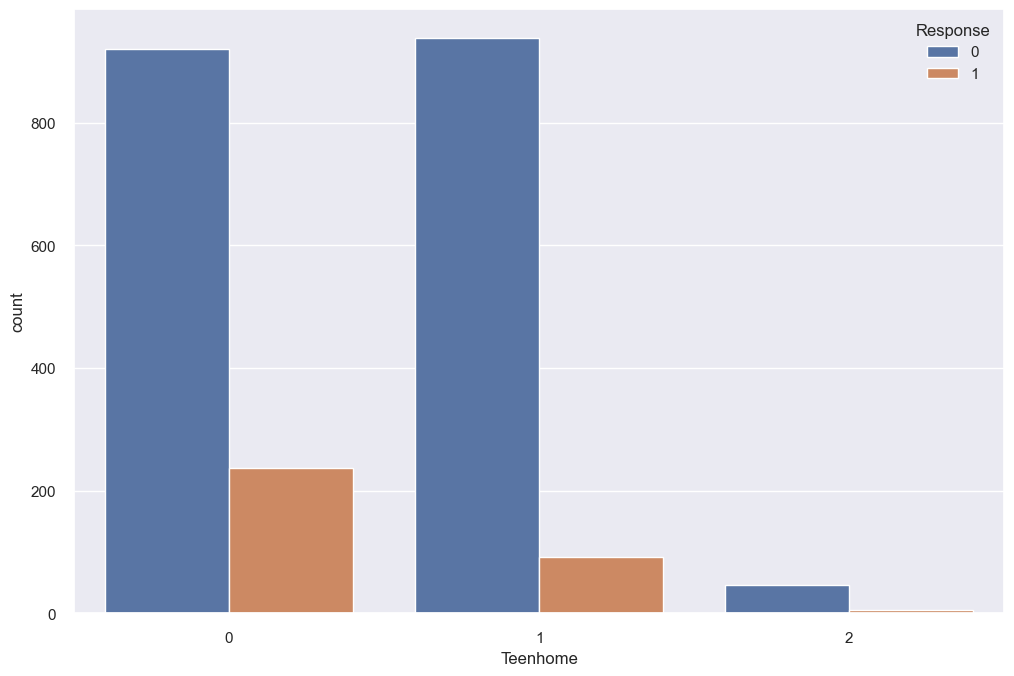

In [12]:
ax = sns.countplot(x="Teenhome", hue="Response", data=data)

In [14]:
(rawData[["Teenhome", "Response"]].groupby(['Teenhome']).sum()/rawData[["Teenhome", "Response"]].groupby(['Teenhome']).count()).sort_values('Response')

,Response
Teenhome,
1,0.089320
2,0.096154
0,0.204663


### Marital Status

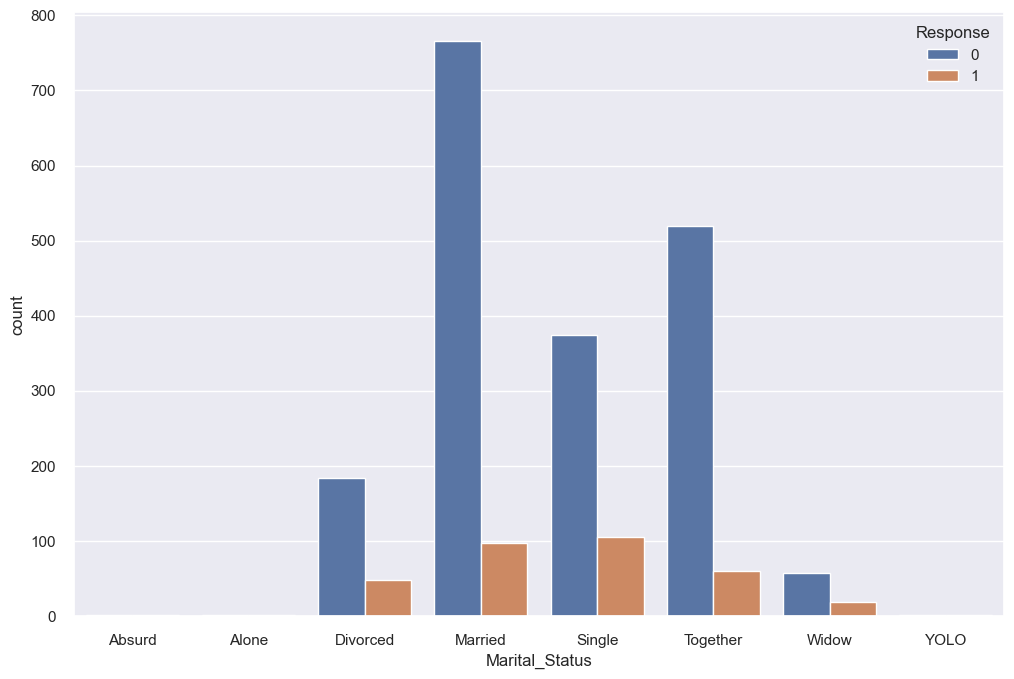

In [90]:
ax = sns.countplot(x="Marital_Status", hue="Response", data=data)

In [91]:
#Check what marital status is more likely to respond
(rawData[["Marital_Status", "Response"]].groupby(['Marital_Status']).sum()/rawData[["Marital_Status", "Response"]].groupby(['Marital_Status']).count()).sort_values('Response')

,Response
Marital_Status,
Together,0.103448
Married,0.113426
Divorced,0.206897
Single,0.220833
Widow,0.246753
Alone,0.333333
Absurd,0.500000
YOLO,0.500000


### Education

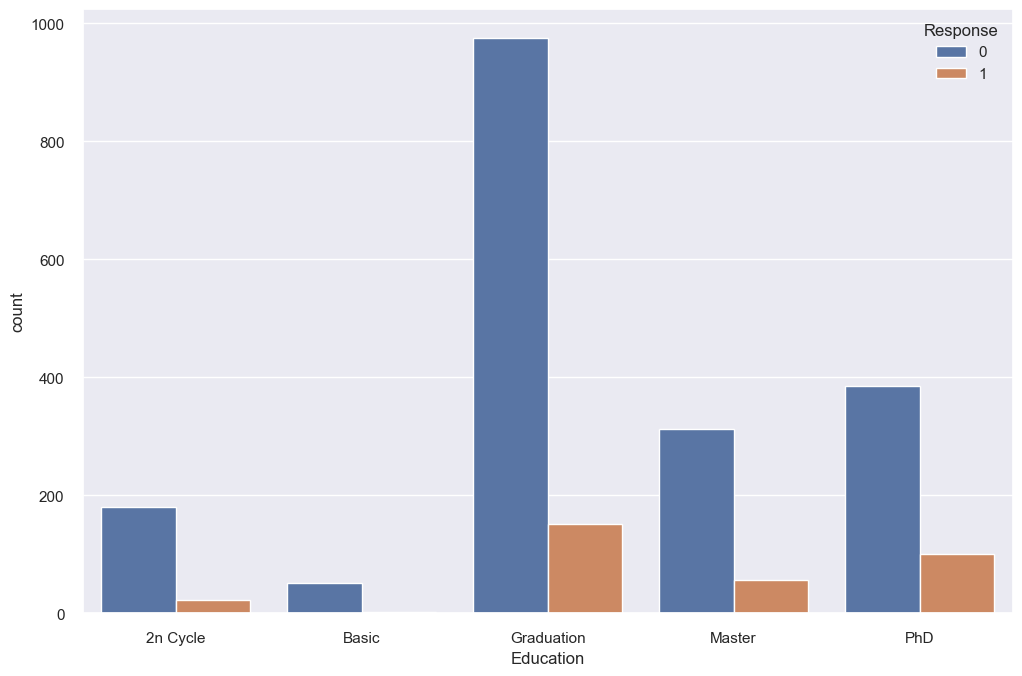

In [92]:
ax = sns.countplot(x="Education", hue="Response" , data=data)

In [93]:
#Check what education level is more likely to respond
(rawData[["Education", "Response"]].groupby(['Education']).sum()/rawData[["Education", "Response"]].groupby(['Education']).count()).sort_values('Response')



,Response
Education,
Basic,0.037037
2n Cycle,0.108374
Graduation,0.134871
Master,0.154054
PhD,0.207819


### year_birth / age

Text(0.5, 0, 'Response 1')

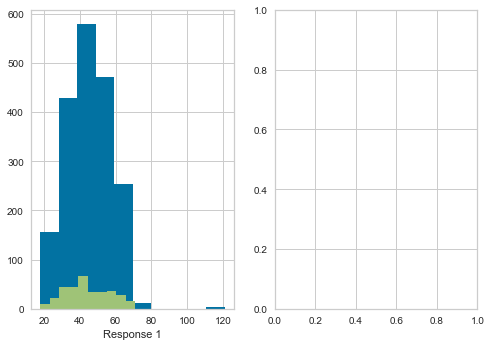

In [40]:
data["age"] = mostRecentDate.year - data["Year_Birth"]

yearData = data[["age","Response"]]
response0 = yearData[yearData["Response"]==0]
response1 = yearData[yearData["Response"]==1]
fig, axs = plt.subplots(1, 2)

axs[0].hist(response0["age"])
axs[0].set_xlabel('Response 0')
axs[0].hist(response1["age"])
axs[0].set_xlabel('Response 1')

### Country

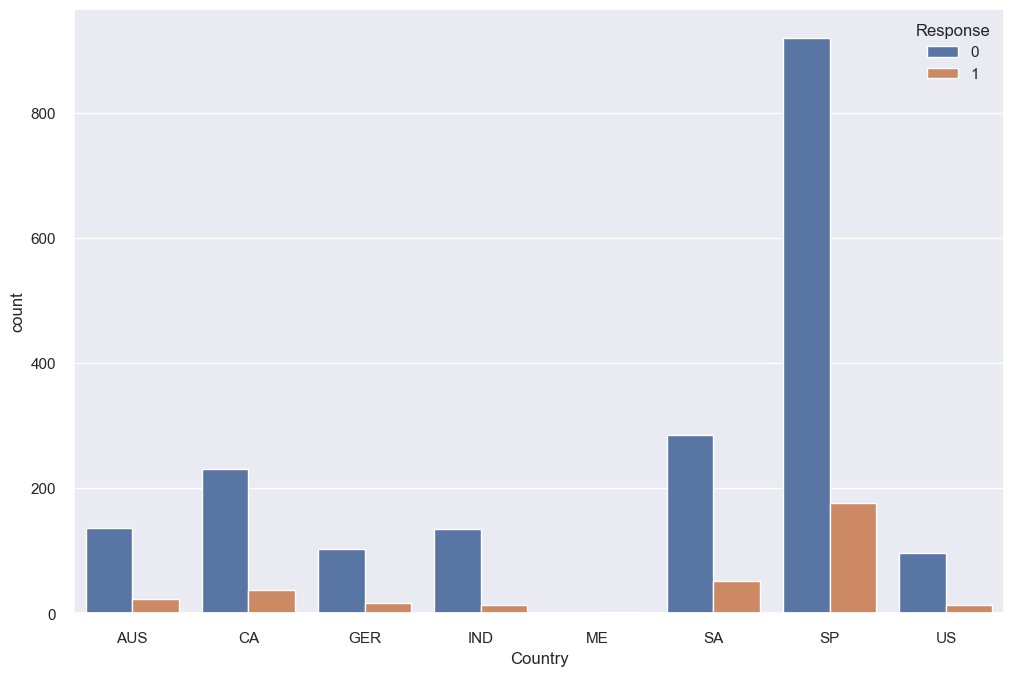

In [47]:
ax = sns.countplot(x="Country", hue="Response", data=data)

In [94]:
#Check what education level is more likely to respond
(rawData[["Country", "Response"]].groupby(['Country']).sum()/rawData[["Country", "Response"]].groupby(['Country']).count()).sort_values('Response')


,Response
Country,
IND,0.087838
US,0.119266
GER,0.141667
CA,0.141791
AUS,0.143750
SA,0.154303
SP,0.160731
ME,0.666667


### dates

### Correlation Matrix

<AxesSubplot:>

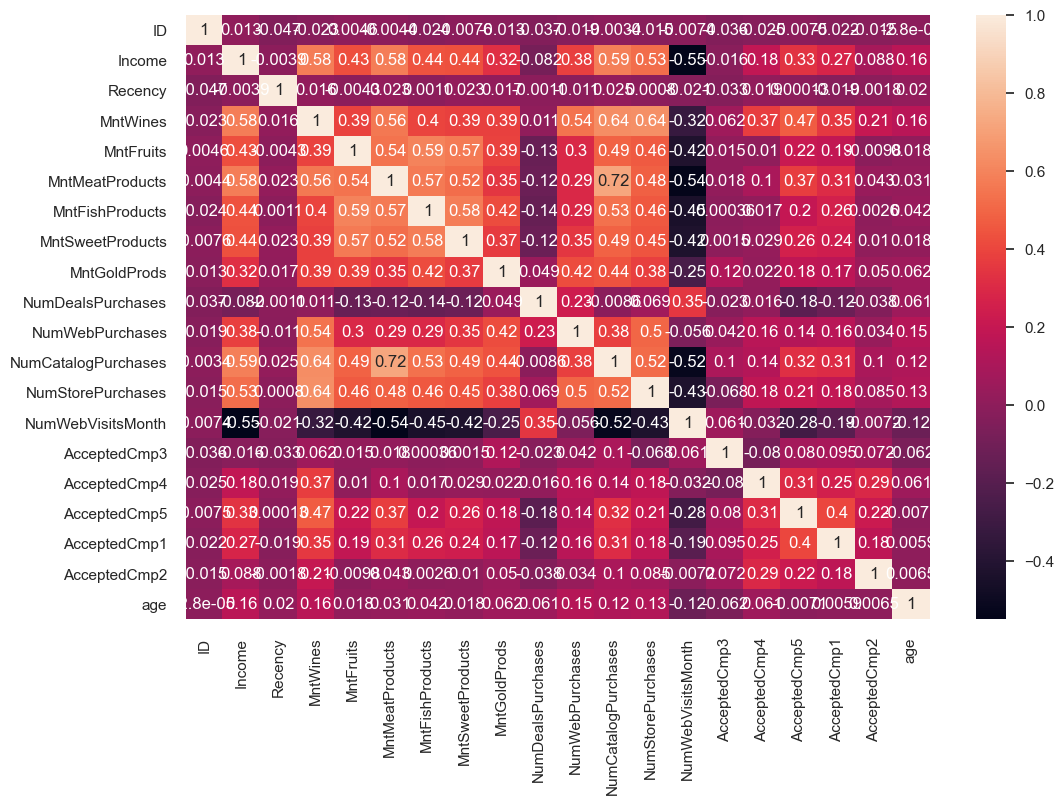

In [48]:
corData = data.drop(columns=["Year_Birth", "Education", "Marital_Status", "Dt_Customer", "Country"])
corMatrix = corData.corr()
sns.heatmap(corMatrix, annot=True)

### Mnt columns analysis

In [95]:
response0 = data[data["Response"]==0]
response1 = data[data["Response"]==1]

(array([107.,  35.,  38.,  29.,  28.,  26.,  29.,  23.,  14.,   5.]),
 array([   9. ,  155.4,  301.8,  448.2,  594.6,  741. ,  887.4, 1033.8,
        1180.2, 1326.6, 1473. ]),
 <BarContainer object of 10 artists>)

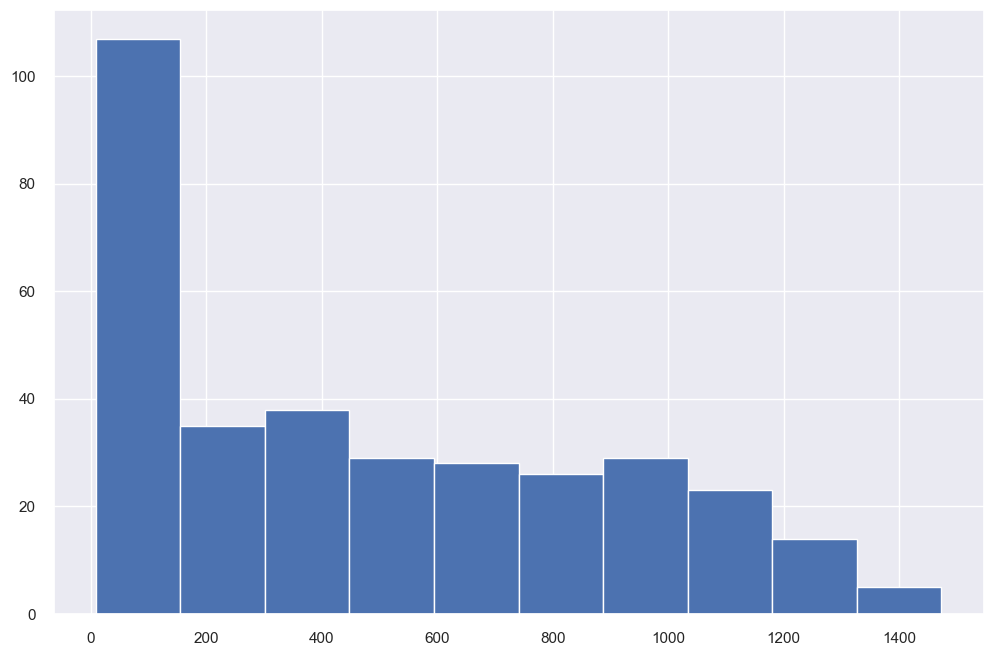

In [50]:
totalSpend = response1["MntFruits"] + response1["MntMeatProducts"] + response1["MntFishProducts"] + response1["MntSweetProducts"] + response1["MntGoldProds"] 
plt.hist(totalSpend)

The graph excluded wine product, because wine product is signifantly more expensive than others

Text(0.5, 0, 'MntGoldProds')

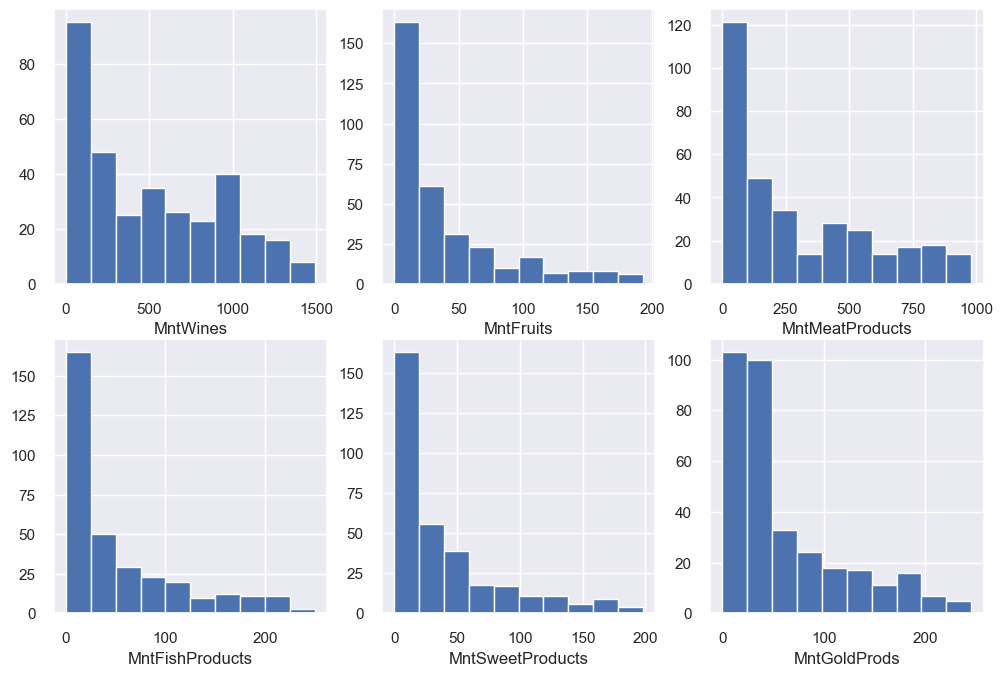

In [51]:
fig, axs = plt.subplots(2, 3)

axs[0,0].hist(response1["MntWines"])
axs[0,0].set_xlabel("MntWines")
axs[0,1].hist(response1["MntFruits"])
axs[0,1].set_xlabel('MntFruits')
axs[0,2].hist(response1["MntMeatProducts"])
axs[0,2].set_xlabel('MntMeatProducts')
axs[1,0].hist(response1["MntFishProducts"])
axs[1,0].set_xlabel('MntFishProducts')
axs[1,1].hist(response1["MntSweetProducts"])
axs[1,1].set_xlabel('MntSweetProducts')
axs[1,2].hist(response1["MntGoldProds"])
axs[1,2].set_xlabel('MntGoldProds')

### purchase habit analysis


C:\Users\tommy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

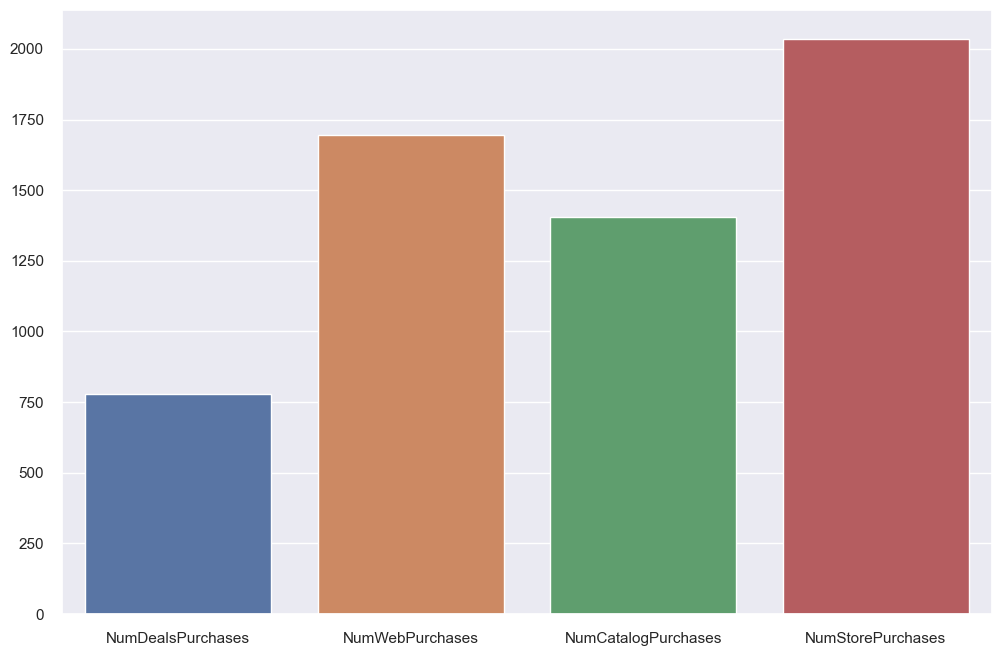

In [96]:
x = ["NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]
y = [response1["NumDealsPurchases"].sum(), response1["NumWebPurchases"].sum(), response1["NumCatalogPurchases"].sum(), response1["NumStorePurchases"].sum()]

sns.barplot(x, y)

(array([78., 41., 42., 39., 31., 25., 23., 21., 12., 22.]),
 array([ 2. ,  3.1,  4.2,  5.3,  6.4,  7.5,  8.6,  9.7, 10.8, 11.9, 13. ]),
 <BarContainer object of 10 artists>)

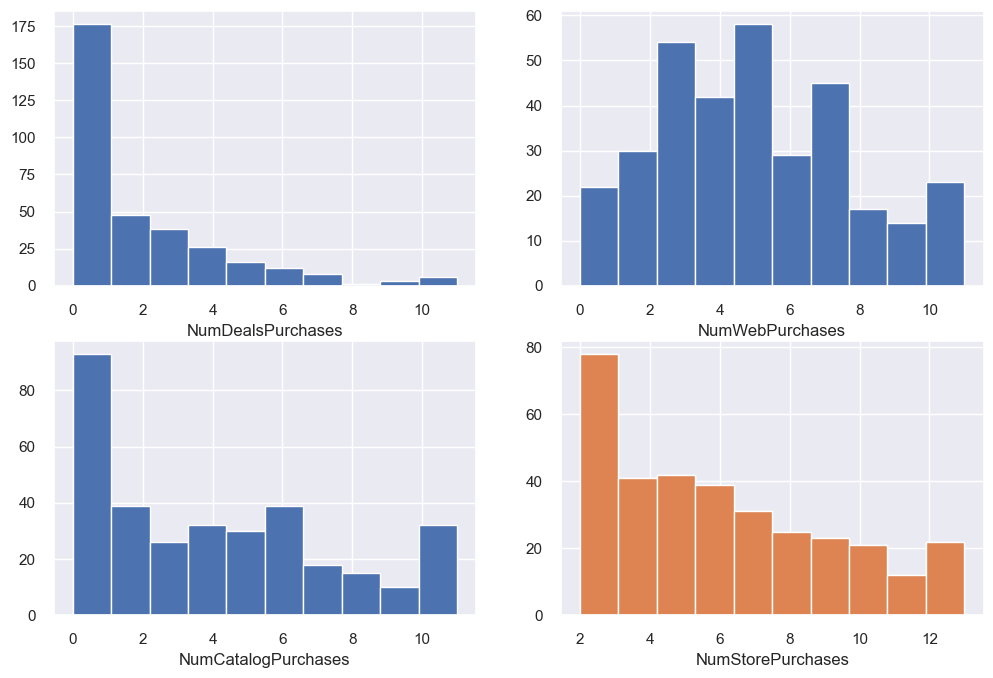

In [100]:
fig, axs = plt.subplots(2, 2)

axs[0,0].hist(response1["NumDealsPurchases"])
axs[0,0].set_xlabel("NumDealsPurchases")
axs[0,1].hist(response1["NumWebPurchases"])
axs[0,1].set_xlabel('NumWebPurchases')
axs[1,0].hist(response1["NumCatalogPurchases"])
axs[1,0].set_xlabel('NumCatalogPurchases')
axs[1,1].hist(response1["NumStorePurchases"])
axs[1,1].set_xlabel('NumStorePurchases')
axs[1,1].hist(response1["NumStorePurchases"])

### number of visits per month

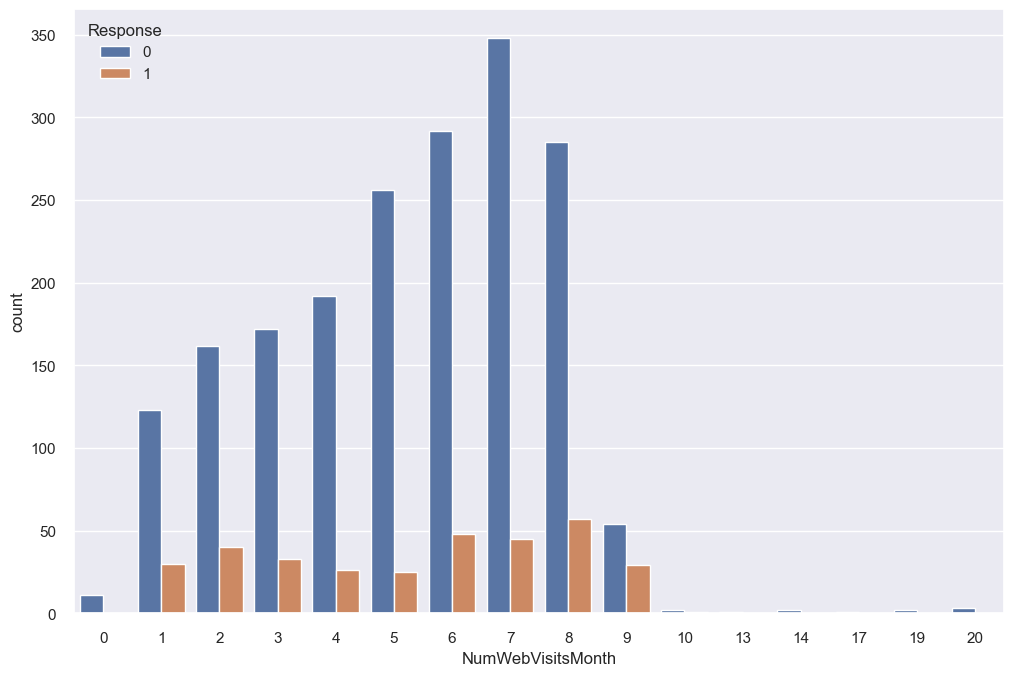

In [113]:
ax = sns.countplot(x="NumWebVisitsMonth", hue="Response", data=data)

In [15]:
(rawData[["NumWebVisitsMonth", "Response"]].groupby(['NumWebVisitsMonth']).sum()/rawData[["NumWebVisitsMonth", "Response"]].groupby(['NumWebVisitsMonth']).count()).sort_values('Response')


,Response
NumWebVisitsMonth,
0,0.000000
13,0.000000
14,0.000000
17,0.000000
19,0.000000
20,0.000000
5,0.088968
7,0.114504
4,0.119266


### Acceptted Campaign

C:\Users\tommy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

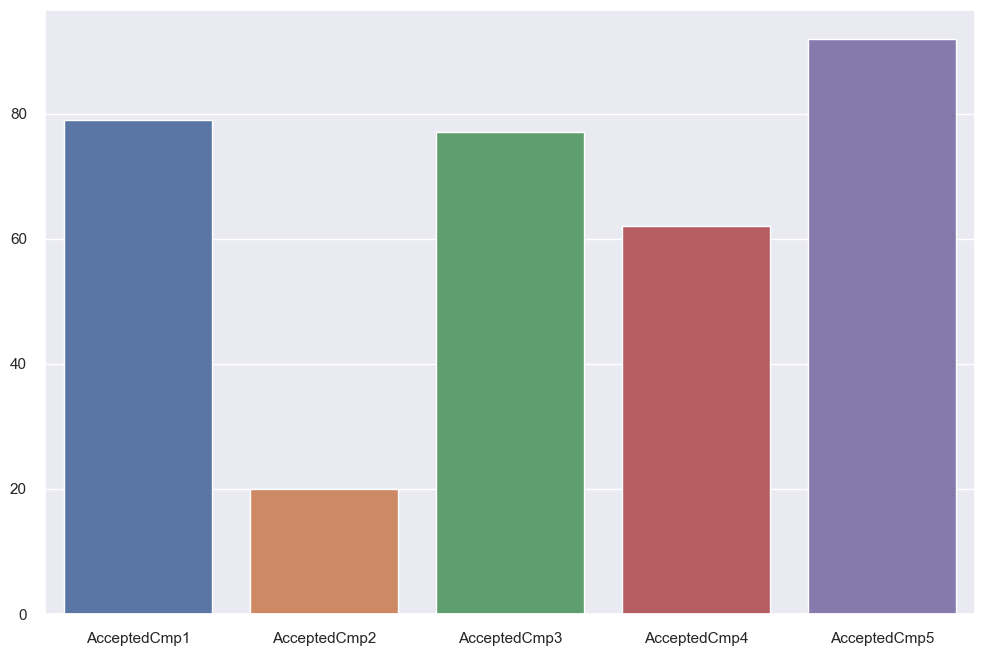

In [102]:
x = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]
y = [response1["AcceptedCmp1"].sum(), response1["AcceptedCmp2"].sum(), response1["AcceptedCmp3"].sum(), response1["AcceptedCmp4"].sum(), response1["AcceptedCmp5"].sum()]

sns.barplot(x, y)

### total campaign accepted

<ipython-input-107-67ca4690f0eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response1["totalCmp"] = response1["AcceptedCmp1"] +response1["AcceptedCmp2"] +response1["AcceptedCmp3"] +response1["AcceptedCmp4"] + response1["AcceptedCmp5"]
C:\Users\tommy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='totalCmp', ylabel='count'>

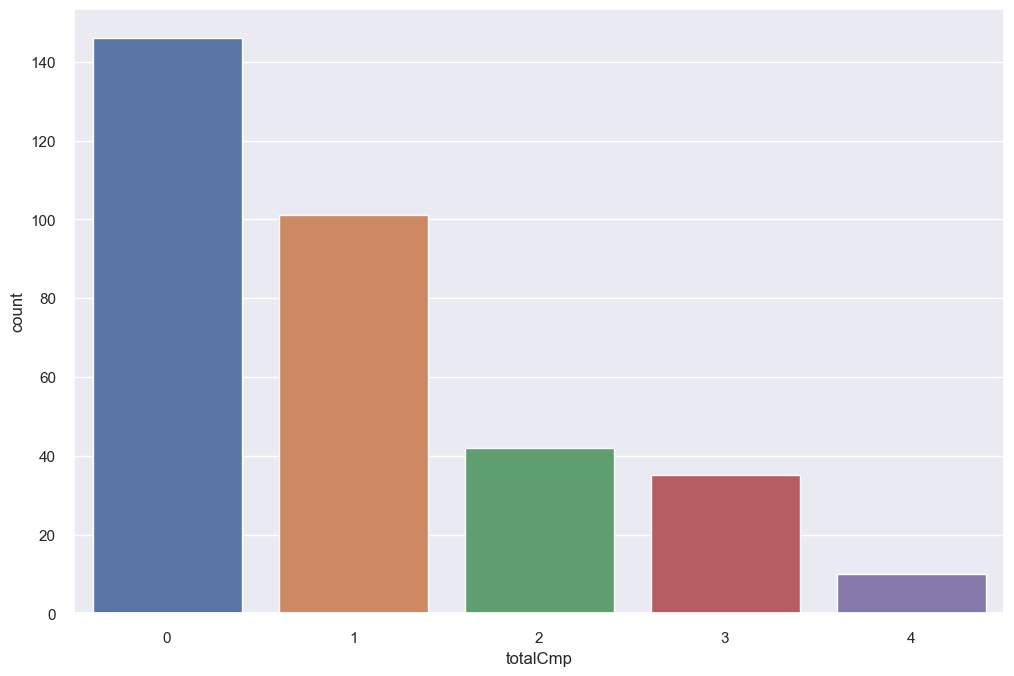

In [107]:
response1["totalCmp"] = response1["AcceptedCmp1"] +response1["AcceptedCmp2"] +response1["AcceptedCmp3"] +response1["AcceptedCmp4"] + response1["AcceptedCmp5"]
sns.countplot(response1["totalCmp"])

### complain


C:\Users\tommy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Complain', ylabel='count'>

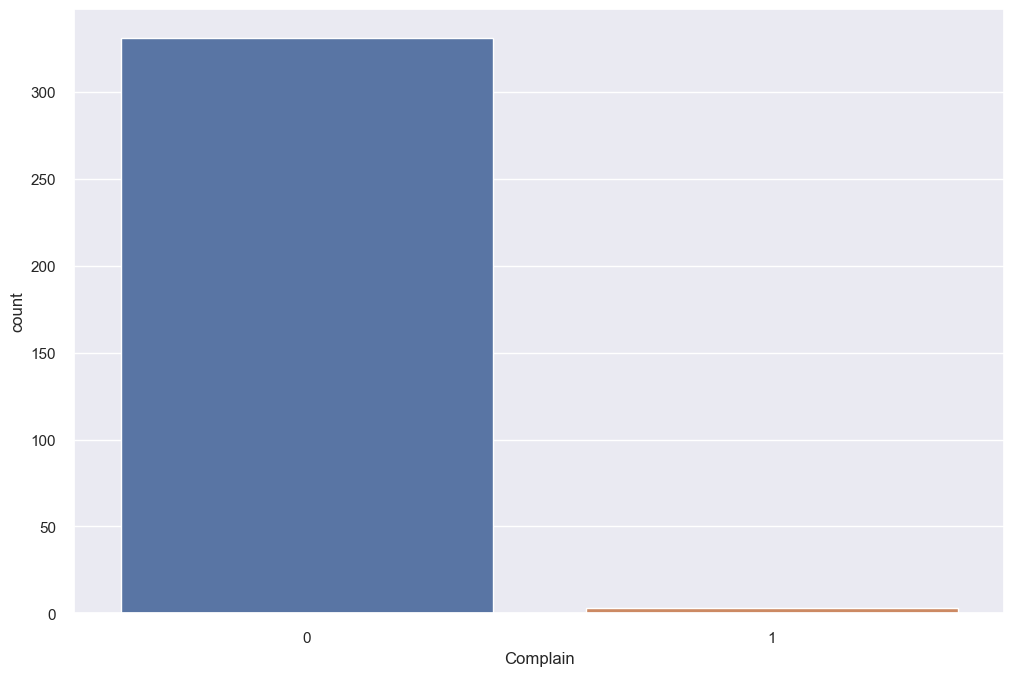

In [112]:
sns.countplot(response1["Complain"])